# Stability verification of a fixed uncertain system (without dynamic programming)

In [13]:
from __future__ import division, print_function

import tensorflow as tf
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from future.builtins import *
from functools import partial
%matplotlib inline

import plotting #plotting from this folder
import matplotlib
import safe_learning

try:
    session.close()
except NameError:
    pass

graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)
session.run(tf.global_variables_initializer())

We start by defining a discretization of the space $[-1, 1]$ with discretization constant $\tau$

In [14]:
discretization = safe_learning.GridWorld([-1, 1], 1001)
tau = 1 / discretization.nindex

print('Grid size: {0}'.format(discretization.nindex))

Grid size: 1001


We define the GP model using one particular sample of the GP, in addition to a stable, closed-loop, linear model.
$$x_{l+1} = 0.25 x_k + g_\pi(x),$$

The prior dynamics are locally asymptotically stable. Moreover, in the one-dimensional case, the dynamics are stable as long as $|x_{k+1}| \leq |x_{k}|$.

In [15]:
# Observation noise
noise_var = 0.01 ** 2

with tf.variable_scope('gp'):
    # Mean dynamics
    mean_function = safe_learning.LinearSystem((0.25, 0.), name='mean_dynamics')

    kernel = (gpflow.kernels.Matern32(1, lengthscales=1, variance=0.4**2, active_dims=[0])
              * gpflow.kernels.Linear(1, active_dims=[0]))

    gp = safe_learning.GPRCached(np.empty((0, 2), dtype=safe_learning.config.np_dtype),
                        np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                        kernel,
                        mean_function=mean_function)
    gp.likelihood.variance = noise_var

    gpfun = safe_learning.GaussianProcess(gp, name='gp_dynamics')

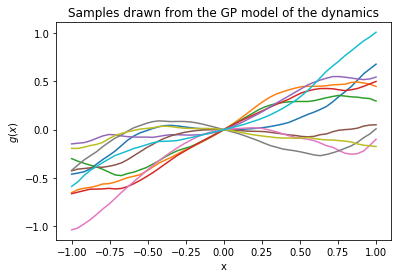

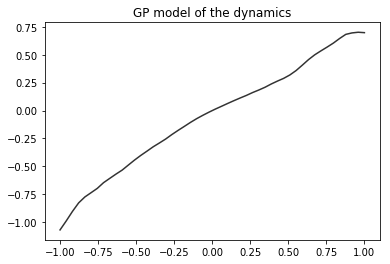

In [16]:
# Define one sample as the true dynamics
np.random.seed(5)

# # Set up a discretization
sample_disc = np.hstack((np.linspace(-1, 1, 50)[:, None],
                         np.zeros((50, 1))))

# # Draw samples
fs = safe_learning.sample_gp_function(sample_disc, gpfun, number=10, return_function=False)
plt.plot(sample_disc[:, 0], fs.T)

plt.ylabel('$g(x)$')
plt.xlabel('x')
plt.title('Samples drawn from the GP model of the dynamics')
plt.show()


true_dynamics = safe_learning.sample_gp_function(
    sample_disc,
    gpfun)[0]

# Plot the basic model
with tf.variable_scope('plot_true_dynamics'):
    true_y = true_dynamics(sample_disc, noise=False).eval(feed_dict=true_dynamics.feed_dict)
plt.plot(sample_disc[:, 0], true_y, color='black', alpha=0.8)
plt.title('GP model of the dynamics')
plt.show()

In [17]:
# lyapunov_function = safe_learning.QuadraticFunction(np.array([[1]]))
lyapunov_disc = safe_learning.GridWorld([-1., 1.], 3)
lyapunov_function = safe_learning.Triangulation(lyapunov_disc, [1, 0, 1], name='lyapunov_function')

dynamics = gpfun
policy = safe_learning.LinearSystem(np.array([0.]), name='policy')

# Lipschitz constant
# L_dyn = 0.25 + dynamics.beta(0) * np.sqrt(gp.kern.Mat32.variance) / gp.kern.Mat32.lengthscale * np.max(np.abs(extent))
# L_V = np.max(lyapunov_function.gradient(grid))

L_dyn = 0.25
L_V = 1.

lyapunov = safe_learning.Lyapunov(discretization, lyapunov_function, dynamics, L_dyn, L_V, tau, policy)

# Specify the desired accuracy
# accuracy = np.max(lyapunov.V) / 1e10

## Safety based on GP model

Let's start by plotting the prior over the dynamics and the associated prior over $\dot{V}(x)$.

(1001, 1)
(1001, 1)


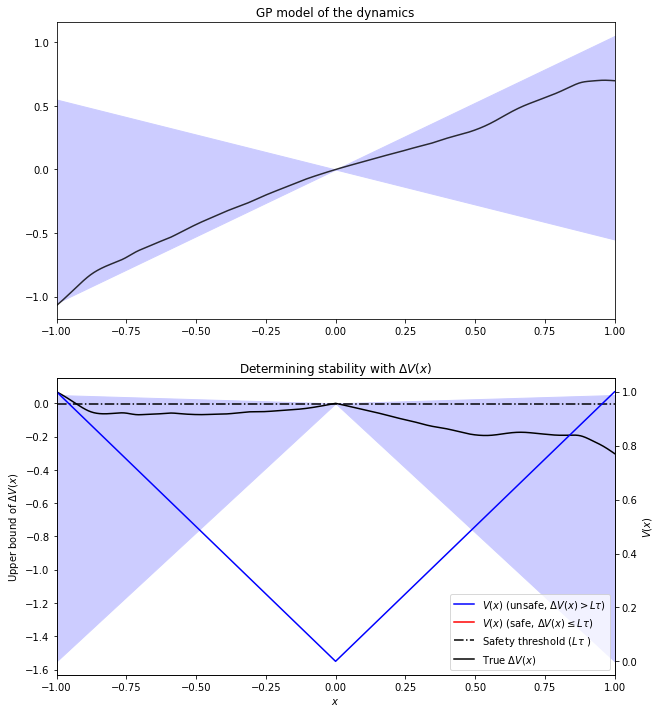

In [18]:
lyapunov.update_safe_set()
plotting.plot_lyapunov_1d(lyapunov, true_dynamics, legend=True)

Clearly the model does not allow us to classify any states as safe ($\dot{V} < -L \tau$). However, as a starting point, we assume that we know that the system is asymptotially stable within some initial set, $\mathcal{S}_0$:

$$\mathcal{S}_0 = \{ x \in \mathbb{R} \,|\, |x| < 0.2 \}$$

In [19]:
lyapunov.initial_safe_set = np.abs(lyapunov.discretization.all_points.squeeze()) < 0.2

## Online learning
As we sample within this initial safe set, we gain more knowledge about the system. In particular, we iteratively select the state withing the safe set, $\mathcal{S}_n$, where the dynamics are the most uncertain (highest variance).

In [20]:
grid = lyapunov.discretization.all_points
lyapunov.update_safe_set()

with tf.variable_scope('sample_new_safe_point'):
    safe_set = tf.placeholder(safe_learning.config.dtype, [None, None])
    _, dynamics_std_tf = lyapunov.dynamics(safe_set, lyapunov.policy(safe_set))
    
                                           
    tf_max_state = tf.placeholder(safe_learning.config.dtype, [1, None])
    tf_max_action = lyapunov.policy(tf_max_state)
    tf_measurement = true_dynamics(tf_max_state, tf_max_action)
    
feed_dict = lyapunov.dynamics.feed_dict
                                        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Maximum uncertainty in safe set
    safe_grid = grid[lyapunov.safe_set]
                                        
    feed_dict[safe_set] = safe_grid
    dynamics_std = dynamics_std_tf.eval(feed_dict=feed_dict)
    
    max_id = np.argmax(dynamics_std)
    max_state = safe_grid[[max_id], :].copy()
                                           
    feed_dict[tf_max_state] = max_state
    max_action, measurement = session.run([tf_max_action, tf_measurement],
                                          feed_dict=feed_dict)
                                   
    arg = np.hstack((max_state, max_action))
    lyapunov.dynamics.add_data_point(arg, measurement)
    lyapunov.update_safe_set()

In [21]:
# Update the GP model a couple of times
for i in range(4):
    update_gp()

(1001, 1)
(1001, 1)


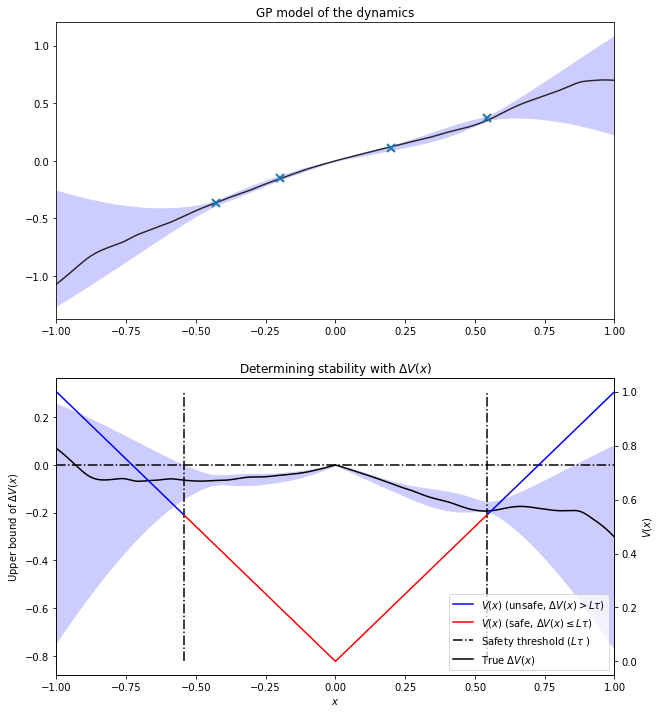

In [22]:
# Plot the new safe set
plotting.plot_lyapunov_1d(lyapunov, true_dynamics, legend=True)

We continue to sample like this, until we find the maximum safe set

(1001, 1)
(1001, 1)


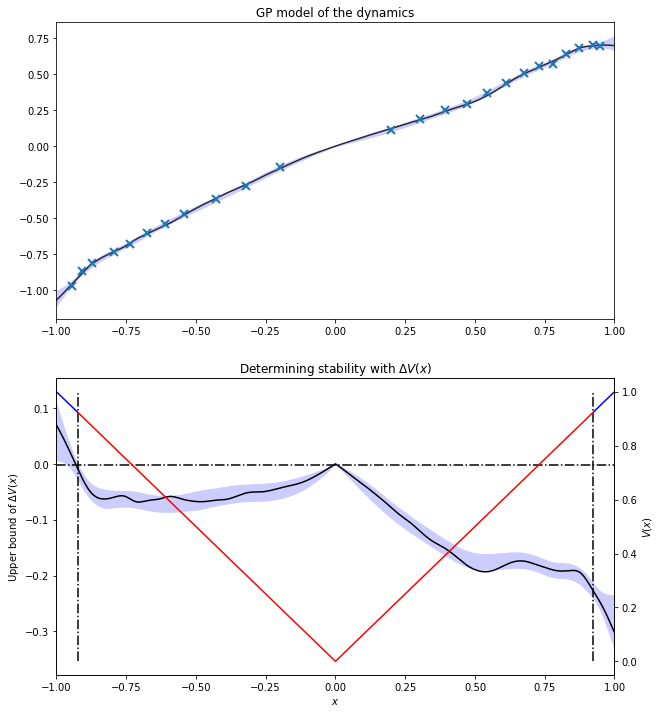

In [23]:
for i in range(20):
    update_gp()

lyapunov.update_safe_set()
plotting.plot_lyapunov_1d(lyapunov, true_dynamics, legend=False)

In [24]:
plotting.show_graph(tf.get_default_graph())